# Predicción del precio en Airbnb

## Model de regresión con Random Forest

### Librerías

In [1]:
## IMPORTS
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# https://ipython.readthedocs.io/en/stable/interactive/plotting.html
%matplotlib inline 

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Leemos dataframe de train limpio
airbnb = pd.read_csv('./train_clean.csv', sep=';', decimal='.')

### Entrenamiento de modelo Random Forest

Entrenamos nuevamente el modelo Random Forest con la selección de características realizada en el notebook "PracticaML-SofiaBenitez-Seleccion_variables.ipynb"

In [3]:
# Selección de 25 características
#sel_var = feature_names[indices][0:25]
#sel_var = ['Room Type', 'Accommodates', 'Cleaning Fee', 'Has AC',
#       'Guests Included', 'Bathrooms', 'Security Deposit', 'Latitude',
#       'Host Listings Count', 'Longitude', 'Minimum Nights', 'Extra People',
#       'Availability 365', 'Days Since Last Review', 'Days As Host',
#       'Neigh_Centro', 'Review Scores Rating', 'Number of Reviews',
#       'Review Scores Location', 'Has Ascensor', 'Property Type',
#       'Neigh_Latina', 'Review Scores Cleanliness', 'Host Response Time',
#       'Cancellation Policy']
# Selección de 18 características
sel_var = ['Room Type', 'Accommodates', 'Cleaning Fee', 'Has AC',
       'Guests Included', 'Bathrooms', 'Security Deposit', 'Latitude',
       'Host Listings Count', 'Longitude', 'Minimum Nights', 'Extra People',
       'Availability 365', 'Days Since Last Review', 'Days As Host',
       'Neigh_Centro', 'Review Scores Rating', 'Number of Reviews']

In [4]:
new_list_cols = sel_var
airbnb_data = airbnb[['Price'] + new_list_cols]

data = airbnb_data.values

y_train = data[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data[:,1:]      # nos quedamos con el resto

feature_names = airbnb_data.columns[1:]

In [5]:
# grid search
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

maxDepth = [5, 15, 30, 50]
n_estim = [200, 500, 700, 1000]

tuned_parameters = {'max_depth': maxDepth, 'n_estimators': n_estim} 
                    

grid = GridSearchCV(RandomForestRegressor(random_state=0, max_features='sqrt'), 
                    param_grid=tuned_parameters,cv=10) #n_estimators=200,
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

#scores = np.array(grid.cv_results_['mean_test_score'])
#plt.plot(maxDepth,scores,'-o')
#plt.xlabel('max_depth')
#plt.ylabel('10-fold ACC')
#
#plt.show()

best mean cross-validation score: 0.684
best parameters: {'max_depth': 30, 'n_estimators': 700}


In [6]:
# Decidimos usar un valor de max_depth de 10 para obtener un modelo con menos prestaciones pero que sea capaz
# de generalizar
maxDepthOptimo = 10 #grid.best_params_['max_depth']
print("maxDepthOptimo: {}".format(maxDepthOptimo))
n_estimOptimo = grid.best_params_['n_estimators']
print("n_estim: {}".format(n_estimOptimo))
bagModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))



maxDepthOptimo: 10
n_estim: 700
Train:  0.821339696996964


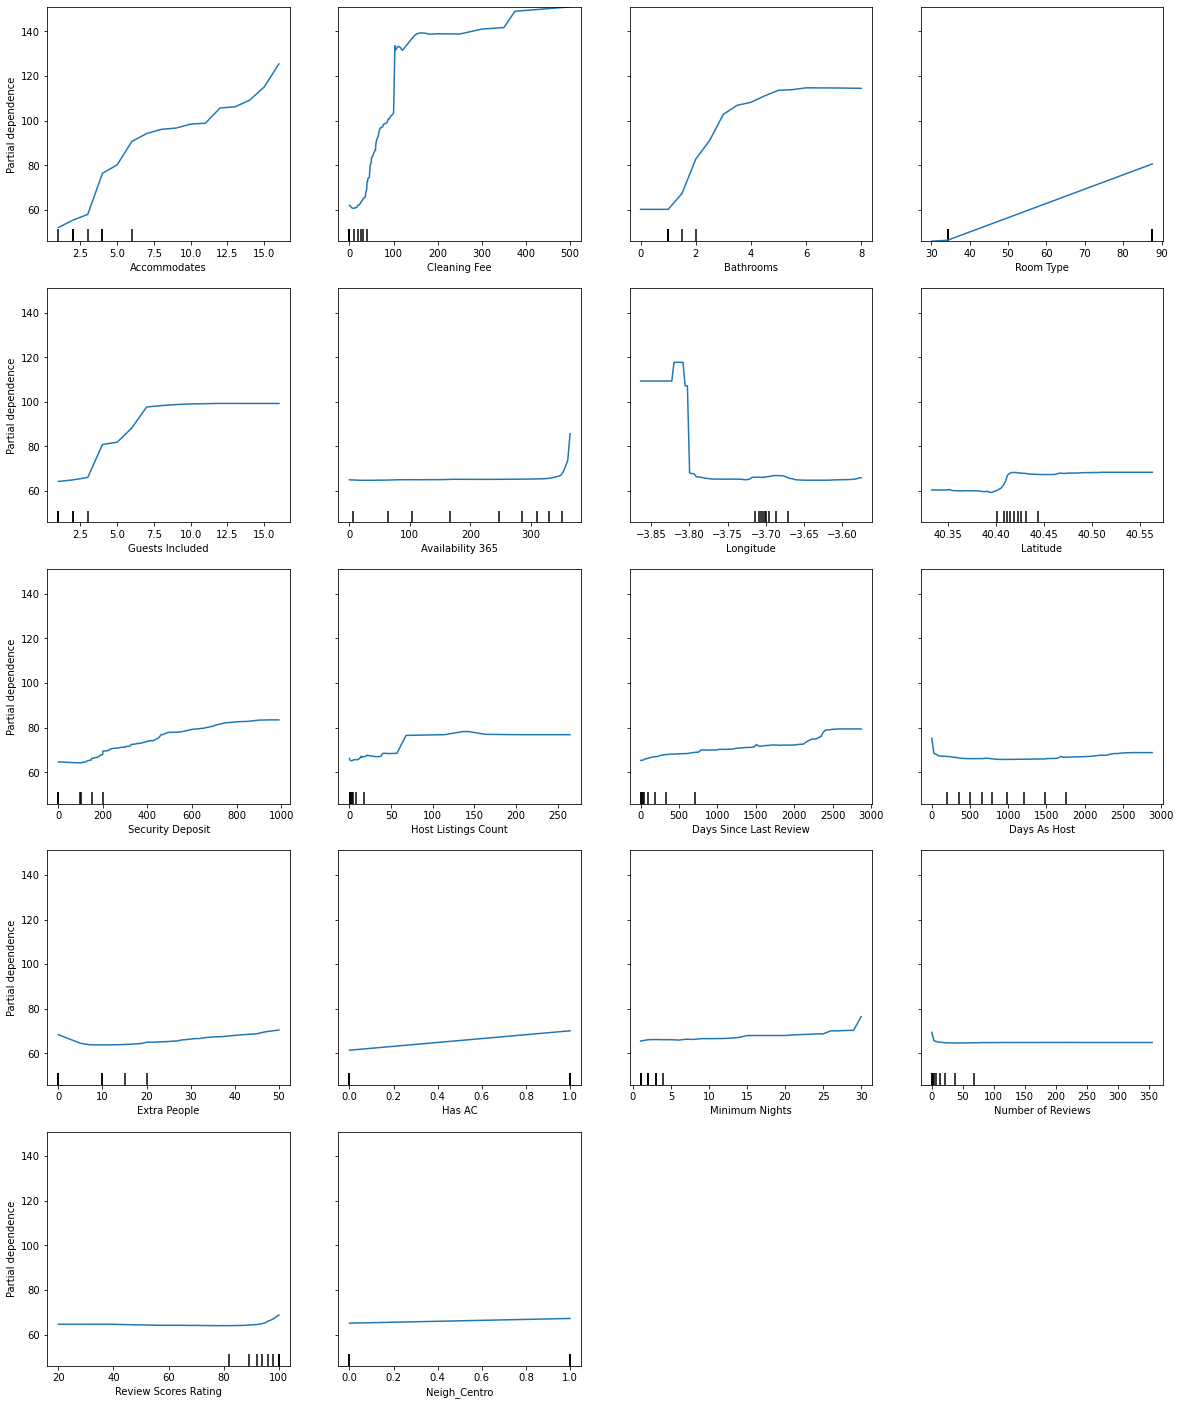

In [7]:
# Representamos la dependencia de cada característica con la variable target
from sklearn.inspection import plot_partial_dependence

importances = bagModel.feature_importances_
importances = importances / np.max(importances)
indices = np.argsort(importances)[::-1]

plot_partial_dependence(bagModel, X_train, indices, feature_names=feature_names, percentiles=(0.0, 1.0), n_cols = 4)
fig = plt.gcf()
fig.set_size_inches(20,25)
plt.show()

### Validación del conjunto de test

In [8]:
# Leemos el conjunto de test previamente limpiado y preprocesado
test = pd.read_csv('./test_clean.csv', sep=';', decimal='.')

#### Validación del modelo Random Forest

Test:  0.6420957742471727
[[0.42647537 0.4258325  0.42531512 0.42472213]
 [0.32103478 0.32098812 0.32093907 0.32023764]
 [0.31676208 0.31629595 0.31593793 0.31628979]
 [0.31956597 0.31749879 0.31787798 0.31747684]]


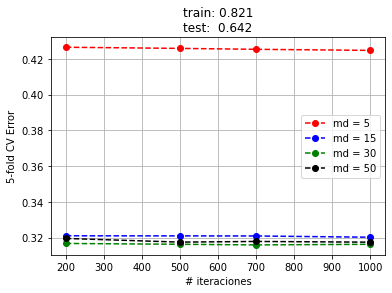

In [9]:
test_data = test[['Price'] + new_list_cols]

test_val = test_data.values

y_test = test_val[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = test_val[:,1:]      # nos quedamos con el resto

feature_names = test_data.columns[1:]
print("Test: ",bagModel.score(X_test,y_test))

error = 1-grid.cv_results_['mean_test_score'].reshape(len(maxDepth),len(n_estim))
print(error)
colors = ['r','b','g','k','m','c']
for i,md in enumerate(maxDepth):    
    plt.plot(n_estim,error[i,:],colors[i] + '--o',label='md = %g'%md)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bagModel.score(X_train,y_train),bagModel.score(X_test,y_test)))
plt.grid()
plt.show()

**Evaluación del modelo con 25 variables (métrica score R2)**

 - Train:  0.8156559928378898
 - Test:  0.6298620146192064

Los resultados obtenidos indican que el modelo tiene overfitting, es decir, no es capaz de generalizar.


**Evaluación del modelo con 18 variables (métrica score R2)**

 - Train:  0.821339696996964
 - Test:  0.6420957742471727

Los resultados siguen presentando overfitting y por tanto sigue sin ser capaz de generalizar.

**Conclusiones:**

Con el análisis realizado hasta ahora se observa que el análisis exploratorio y la selección de características no son los óptimos para la aplicación de un modelo Random Forest. Con los grupos de variables seleccionados el modelo resultante (a falta de un análisis más exhaustivo de los hiperparámetros) tiene overfitting y no es capaz de generalizar a la vista de los resultados del coeficiente de determinación R2 empleado como métrica de evaluación de este modelo.   realizado  modelo Random Forest con los hiperparámetros encontrados.

Como pasos siguientes se podría:

 - Contrastar con otro modelo de Regresión (en el notebook PracticaML-SofiaBenitez_GBR.ipynb)
 - Generar nuevas características a partir del conocimiento del dominio que permitan extraer valor y sean capaces de proporcionar mejores prestaciones a los modelos entrenados.
